<a href="https://colab.research.google.com/github/AnitaTasnim/GNN_attack_model/blob/main/attack_withi_riccicurvature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import library

In [1]:
!pip install pygod
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pygod: filename=pygod-1.0.0-py3-none-any.whl size=70678 sha256=313af6595c09bafbb21d88ae2605213b2cc89d4ac02ad3ab7d648b8cb157ff1c
  Stored in directory: /root/.cache/pip/wheels/19/4f/5e/d4a08c3476915cb8021462fe4129680c598ebce8b100f59ecf
Successfully built pygod
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=594210588de29d93bb7323c2585e77e10f9434b9e44e32a84bccc973d57a56b1
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [2]:
import torch
import torch.nn as nn
from torch.nn import init
import torch_geometric
from pygod.utils import load_data
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


In [3]:
import torch

In [4]:
import matplotlib.pyplot as plt

#about dataset

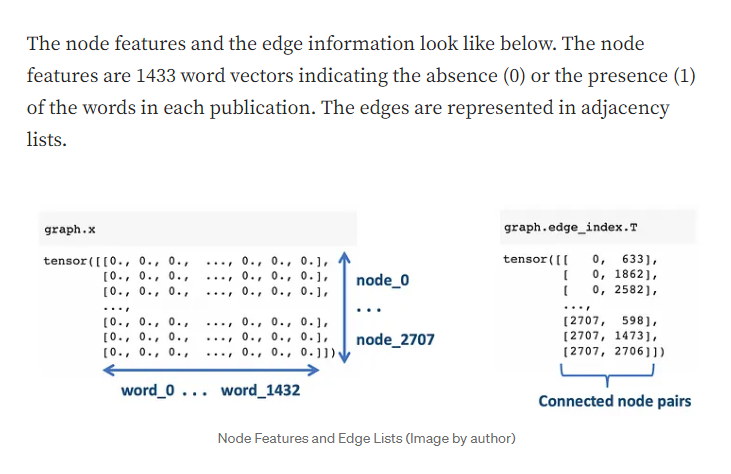

In [5]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]

Processing...
Done!


In [6]:
graph.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
graph.edge_index.T #connected node pairs

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [9]:
adj = dataset[0].edge_index.t() ## Get the adjacency matrix,
adj

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [10]:
graph.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [11]:
features = dataset[0].x
print(features)
labels = dataset[0].y
print(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 4, 4,  ..., 3, 3, 3])


Each node has one of seven classes which is going to be our model target/label.

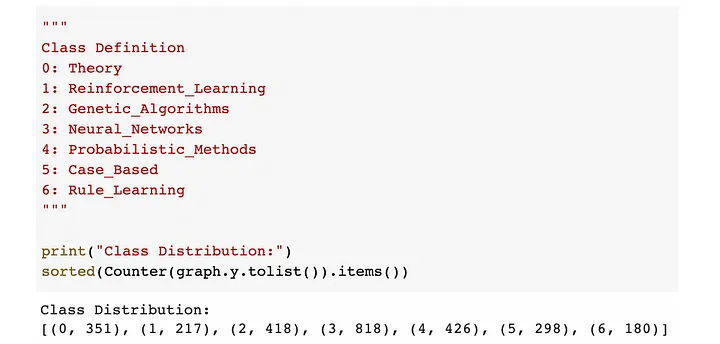

In [12]:
graph.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [13]:


# Get the train, validation, and test indices
idx_train = dataset[0].train_mask.nonzero().view(-1)
idx_val = dataset[0].val_mask.nonzero().view(-1)
idx_test = dataset[0].test_mask.nonzero().view(-1)

# Print some dataset statistics
print(f"Number of nodes: {adj.size(0)}")
print(f"Number of edges: {adj.sum().item() // 2}")  # Divide by 2 because the graph is undirected
print(f"Number of features per node: {features.size(1)}")
print(f"Number of classes: {int(labels.max()) + 1}")
print(f"Number of training nodes: {len(idx_train)}")
print(f"Number of validation nodes: {len(idx_val)}")
print(f"Number of test nodes: {len(idx_test)}")

Number of nodes: 10556
Number of edges: 13820218
Number of features per node: 1433
Number of classes: 7
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


In [14]:
#combining for test, the test and validation:
import numpy as np
idx_unlabeled = np.union1d(idx_val, idx_test)
idx_unlabeled[:10]

array([140, 141, 142, 143, 144, 145, 146, 147, 148, 149])

In [15]:
#generate target nodes:
import random
target_number = 10
node_list = random.sample(list(idx_unlabeled),target_number)
node_list

[376, 488, 2495, 2202, 1740, 1992, 633, 2210, 2576, 211]

In [16]:
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [17]:
device

device(type='cuda')

###all nodes degree info

In [18]:
degree_cora = {}
for (u, v) in adj:
    if int(u) in degree_cora:
        degree_cora[int(u)] += 1
    else:
        degree_cora[int(u)] = 1

degree_cora

{0: 3,
 1: 3,
 2: 5,
 3: 1,
 4: 5,
 5: 3,
 6: 4,
 7: 1,
 8: 3,
 9: 2,
 10: 2,
 11: 2,
 12: 4,
 13: 2,
 14: 5,
 15: 4,
 16: 4,
 17: 5,
 18: 5,
 19: 1,
 20: 5,
 21: 2,
 22: 5,
 23: 1,
 24: 7,
 25: 4,
 26: 5,
 27: 4,
 28: 1,
 29: 2,
 30: 6,
 31: 1,
 32: 4,
 33: 9,
 34: 1,
 35: 3,
 36: 8,
 37: 3,
 38: 4,
 39: 7,
 40: 3,
 41: 4,
 42: 2,
 43: 6,
 44: 3,
 45: 6,
 46: 2,
 47: 2,
 48: 9,
 49: 2,
 50: 1,
 51: 6,
 52: 5,
 53: 3,
 54: 2,
 55: 12,
 56: 4,
 57: 1,
 58: 1,
 59: 10,
 60: 3,
 61: 5,
 62: 1,
 63: 1,
 64: 3,
 65: 10,
 66: 1,
 67: 3,
 68: 3,
 69: 7,
 70: 2,
 71: 3,
 72: 2,
 73: 12,
 74: 9,
 75: 6,
 76: 3,
 77: 2,
 78: 3,
 79: 2,
 80: 3,
 81: 4,
 82: 2,
 83: 2,
 84: 5,
 85: 3,
 86: 4,
 87: 3,
 88: 36,
 89: 10,
 90: 4,
 91: 6,
 92: 2,
 93: 4,
 94: 11,
 95: 21,
 96: 1,
 97: 2,
 98: 1,
 99: 6,
 100: 2,
 101: 3,
 102: 8,
 103: 6,
 104: 4,
 105: 4,
 106: 1,
 107: 4,
 108: 3,
 109: 32,
 110: 5,
 111: 6,
 112: 4,
 113: 3,
 114: 3,
 115: 1,
 116: 2,
 117: 2,
 118: 19,
 119: 6,
 120: 5,
 121: 7,
 1

#GCN

In [22]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear, BatchNorm1d

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = BatchNorm1d(hidden_channels)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Third Message Passing Layer
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Fourth Message Passing Layer
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x



In [25]:
graph.edge_index.shape

torch.Size([2, 10556])

Epoch 500/5000:
Train Loss: 1.1803, Train Accuracy: 0.9929, Train Precision: 0.9929, Train Recall: 0.9929
Validation Loss: 1.5214, Validation Accuracy: 0.6440, Validation Precision: 0.6440, Validation Recall: 0.6440
Test Loss: 1.5019, Test Accuracy: 0.6510, Test Precision: 0.6510, Test Recall: 0.6510

Epoch 1000/5000:
Train Loss: 1.1726, Train Accuracy: 0.9929, Train Precision: 0.9929, Train Recall: 0.9929
Validation Loss: 1.5165, Validation Accuracy: 0.6800, Validation Precision: 0.6800, Validation Recall: 0.6800
Test Loss: 1.4990, Test Accuracy: 0.6880, Test Precision: 0.6880, Test Recall: 0.6880

Epoch 1500/5000:
Train Loss: 1.1726, Train Accuracy: 0.9929, Train Precision: 0.9929, Train Recall: 0.9929
Validation Loss: 1.5247, Validation Accuracy: 0.6540, Validation Precision: 0.6540, Validation Recall: 0.6540
Test Loss: 1.5036, Test Accuracy: 0.6830, Test Precision: 0.6830, Test Recall: 0.6830

Epoch 2000/5000:
Train Loss: 1.1726, Train Accuracy: 0.9929, Train Precision: 0.9929, Tra

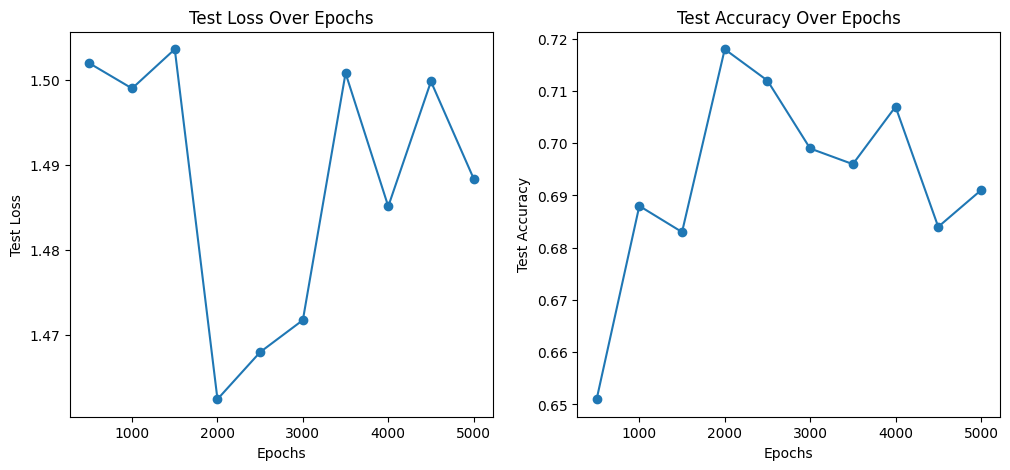

In [23]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Initialize the model and optimizer
num_features = features.size(1)
num_classes = int(labels.max()) + 1
hidden_channels = 64  # You can adjust this as needed
model = GCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define a function for evaluation
def evaluate(model, features,adj,labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj.t())
        logits = logits[mask]
        labels = labels[mask]
        pred = logits.max(1)[1]
        accuracy = accuracy_score(labels, pred)
        precision = precision_score(labels, pred, average='micro')
        recall = recall_score(labels, pred, average='micro')
        return accuracy, precision, recall

# Training loop
num_epochs = 5000
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    logits = model(features, adj.t())
    loss = F.cross_entropy(logits[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        train_loss = loss.item()
        val_loss = F.cross_entropy(logits[idx_val], labels[idx_val]).item()
        test_loss = F.cross_entropy(logits[idx_test], labels[idx_test]).item()

        train_accuracy, train_precision, train_recall = evaluate(model, features,adj,labels, idx_train)
        val_accuracy, val_precision, val_recall = evaluate(model, features,adj,labels, idx_val)
        test_accuracy, test_precision, test_recall = evaluate(model, features,adj,labels, idx_test)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
        print("")


# Plot test loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(500, num_epochs + 1, 500), test_losses, marker='o')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(500, num_epochs + 1, 500), test_accuracies, marker='o')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.show()


In [ ]:
#GCN

#calculate ricci

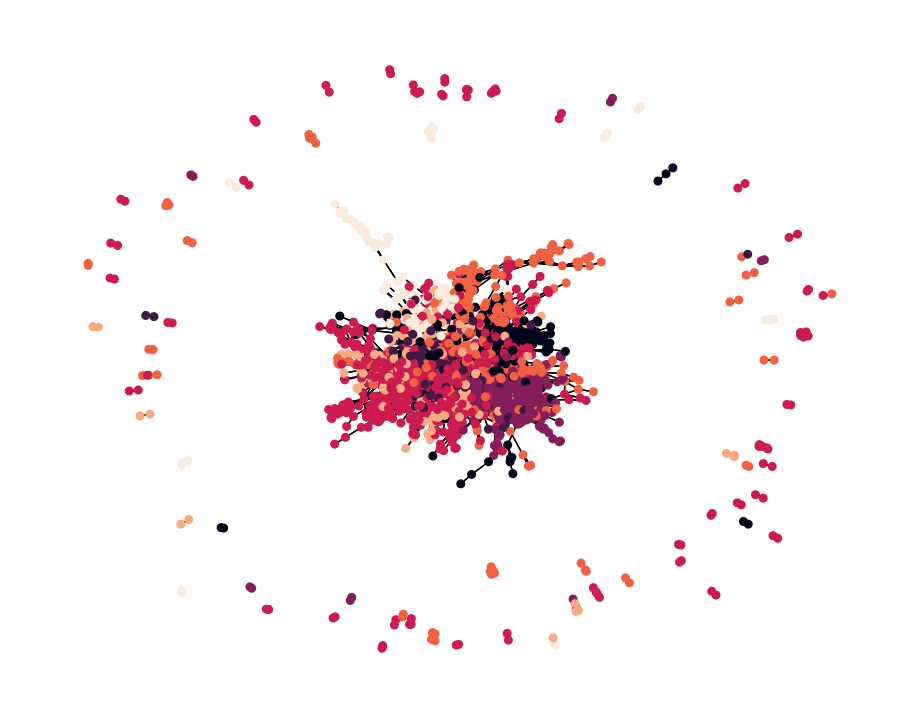

In [60]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

def convert_to_networkx(graph, n_sample=None):

    G = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        G = G.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return G, y


def plot_graph(G, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(G, node_size=30, arrows=False, node_color=y)
    plt.show()


G, y = convert_to_networkx(graph)
plot_graph(G, y)

In [61]:
# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
orc = OllivierRicci(G, alpha=0.5, verbose="TRACE")

INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.


In [64]:
orc.compute_ricci_curvature()
G_orc = orc.G.copy()  # save an intermediate result

TRACE:GraphRicciCurvature:Number of nodes: 2708
TRACE:GraphRicciCurvature:Number of edges: 10556
TRACE:GraphRicciCurvature:Start to compute all pair shortest path.
TRACE:GraphRicciCurvature:2.131117 secs for all pair by NetworKit.
INFO:GraphRicciCurvature:2.937290 secs for Ricci curvature computation.


Karate Club Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (0,633) is 0.000000
Ollivier-Ricci curvature of edge (0,1862) is 0.250000
Ollivier-Ricci curvature of edge (0,2582) is 0.166667
Ollivier-Ricci curvature of edge (1,2) is -0.466667
Ollivier-Ricci curvature of edge (1,652) is -0.166667


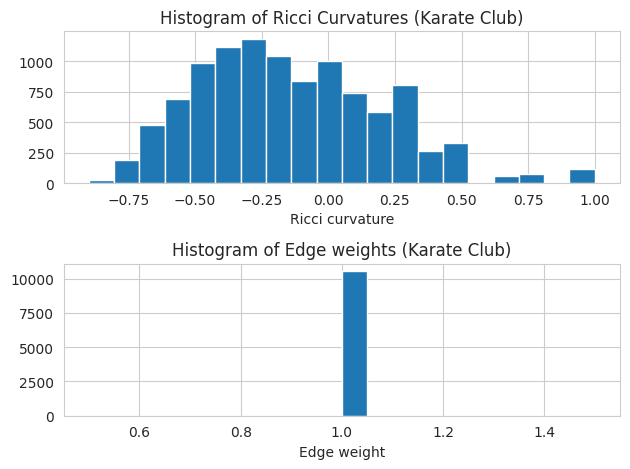

In [65]:
def show_results(G):
    # Print the first five results
    print("Karate Club Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ollivier-Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2]["ricciCurvature"]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, "ricciCurvature").values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures (Karate Club)")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights (Karate Club)")

    plt.tight_layout()

show_results(G_orc)

In [27]:
# # colab setting
!pip install GraphRicciCurvature
!pip install scikit-learn

import networkx as nx
import numpy as np
import math
import importlib

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci

# load python-louvain for modularity computation
import community as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 28.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1368: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [39]:
graph.x.shape[0]

2708

In [32]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [47]:
import networkx as nx
import torch

# Assuming 'graph' is your PyTorch Geometric Data object
G = nx.Graph()

# Add nodes and node attributes
for i in range(graph.num_nodes):
    node_features = graph.x[i].tolist()  # Get node features
    label = graph.y[i].item()  # Get node label
    G.add_node(i, features=node_features, label=label)

# Add edges
edges = graph.edge_index.t().tolist()
G.add_edges_from(edges)

# Now, 'G' is a NetworkX graph representation of your Cora dataset


In [52]:
# Assuming you have your Cora dataset loaded as G and imported GraphRicciCurvature

# Create an instance of OllivierRicci
orc = OllivierRicci(g, alpha=0.5, verbose="TRACE")

# Compute Ricci curvature
orc.compute_ricci_curvature()

# Access Ricci curvature values for each edge
for u, v in g.edges():
    ricci_curvature = g[u][v]["ricciCurvature"]
    print(f"Edge ({u}, {v}) - Ollivier-Ricci curvature: {ricci_curvature}")


INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:GraphRicciCurvature:Number of nodes: 1000
TRACE:GraphRicciCurvature:Number of edges: 1574
TRACE:GraphRicciCurvature:Start to compute all pair shortest path.
TRACE:GraphRicciCurvature:0.223857 secs for all pair by NetworKit.
INFO:GraphRicciCurvature:1.040306 secs for Ricci curvature computation.


KeyError: ignored

In [46]:
# Compute Ollivier-Ricci curvature
orc.compute_ricci_curvature()

# Access curvature values for specific edges
edge_curvature_values = {}
for u, v in nx_graph.edges():
    edge_curvature_values[(u, v)] = nx_graph[u][v]["ricciCurvature"]

# Now 'edge_curvature_values' contains the Ollivier-Ricci curvature values for each edge in your graph

INFO:GraphRicciCurvature:3.365506 secs for Ricci curvature computation.


KeyError: ignored

In [ ]:
def show_results(nx_graph):
    # Print the first five results
    print("Karate Club Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ollivier-Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2]["ricciCurvature"]))


In [ ]:
import networkx as nx

# Assuming you have the Cora dataset as 'data'
nx_graph = nx.Graph()
nx_graph.add_nodes_from(range(dataset.x.shape[0]))
edges = data.edge_index.numpy()
for u, v in edges.T:
    nx_graph.add_edge(u, v, weight=1.0)  # Assign default edge weight of 1.0


In [30]:
edge_curvature_values

{(0, 633): None,
 (0, 1862): None,
 (0, 2582): None,
 (1, 2): None,
 (1, 652): None,
 (1, 654): None,
 (2, 1): None,
 (2, 332): None,
 (2, 1454): None,
 (2, 1666): None,
 (2, 1986): None,
 (3, 2544): None,
 (4, 1016): None,
 (4, 1256): None,
 (4, 1761): None,
 (4, 2175): None,
 (4, 2176): None,
 (5, 1629): None,
 (5, 1659): None,
 (5, 2546): None,
 (6, 373): None,
 (6, 1042): None,
 (6, 1416): None,
 (6, 1602): None,
 (7, 208): None,
 (8, 269): None,
 (8, 281): None,
 (8, 1996): None,
 (9, 723): None,
 (9, 2614): None,
 (10, 476): None,
 (10, 2545): None,
 (11, 1655): None,
 (11, 1839): None,
 (12, 1001): None,
 (12, 1318): None,
 (12, 2661): None,
 (12, 2662): None,
 (13, 1701): None,
 (13, 1810): None,
 (14, 158): None,
 (14, 2034): None,
 (14, 2075): None,
 (14, 2077): None,
 (14, 2668): None,
 (15, 1090): None,
 (15, 1093): None,
 (15, 1271): None,
 (15, 2367): None,
 (16, 970): None,
 (16, 1632): None,
 (16, 2444): None,
 (16, 2642): None,
 (17, 24): None,
 (17, 927): None,
 (17, 

In [31]:
FormanRicci(graph)

NameError: ignored

In [ ]:
 G = nx.karate_club_graph()
>>> frc = FormanRicci(G)
>>> frc.compute_ricci_curvature()
>>> frc.G[0][1]
{'formanCurvature': 0}

##visualize the dataset

<ipython-input-9-24e06c6199ab>:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


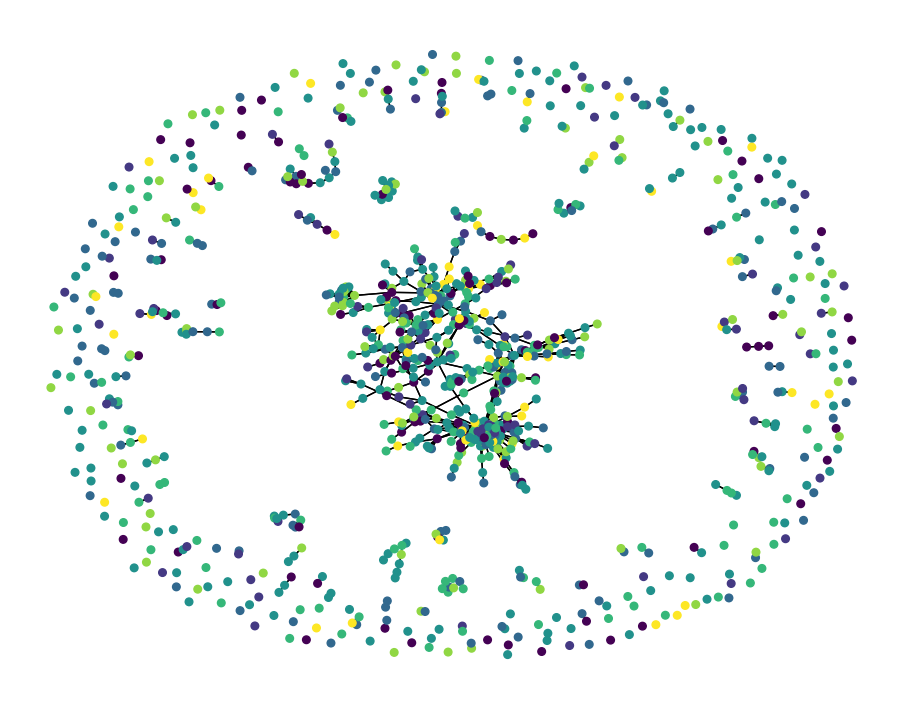

In [9]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show()


g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

#Node Classification

For the node classification problem, we are splitting the nodes into train, valid, and test using the RandomNodeSplit module from PyG (we are replacing the original split masks in the data as it has a too small train set).

In [10]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [13]:

import torch_geometric.transforms as T

# Set a fixed seed for reproducibility
torch.manual_seed(42)  # You can use any integer as the seed

split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)

In [14]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

###visualize train test validation

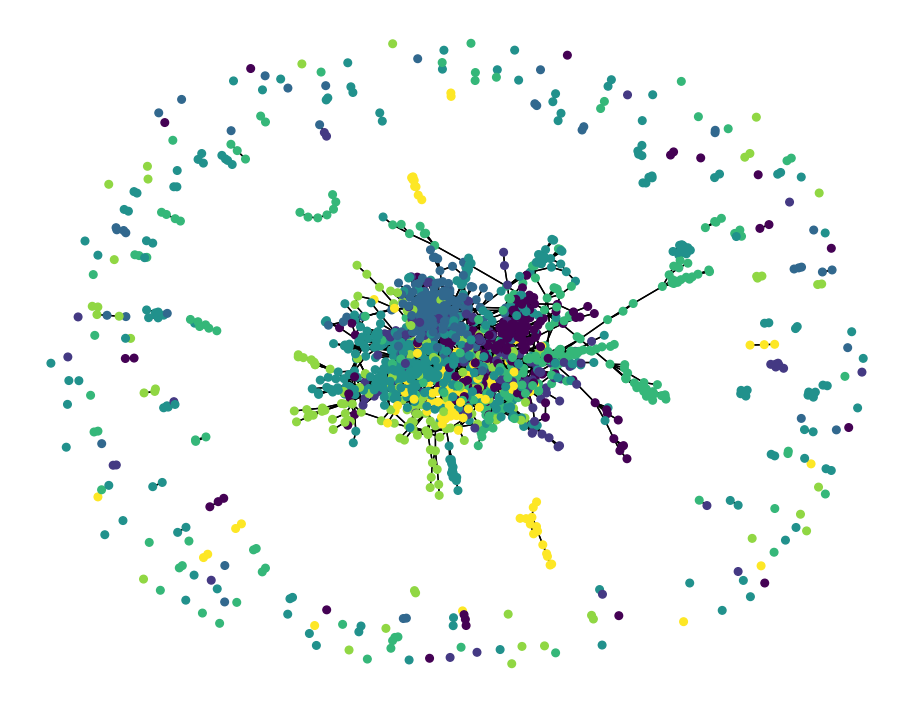

In [19]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph_for_nodes(g, y, nodes):

    plt.figure(figsize=(9, 7))
    subgraph = g.subgraph(nodes)
    nx.draw_spring(subgraph, node_size=30, arrows=False, node_color=[y[node] for node in subgraph.nodes])
    plt.show()

# Assuming you have 'graph' and 'train_nodes' defined
g, y = convert_to_networkx(graph)
plot_graph_for_nodes(g, y, train_nodes)


##GCN on Node Classification

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output


gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')